In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt



In [2]:
data = np.genfromtxt('data/data4.csv', delimiter=',', names=True, missing_values="", filling_values="0")

In [3]:
print('length: ' + str(len(data)))
print('shape: ' + str(data.shape))
# data.dtype.names
print('some col names: ' + str(data.dtype.names[:10]))

length: 1575
shape: (1575,)
some col names: ('date', 'Metal_Bulletin', 'VDM_WDM', 'OPEC_ORB_serie_ROC_7', 'OPEC_ORB_serie_MOM_15', 'OPEC_ORB_serie_MOM_30', 'OPEC_ORB_serie_MOM_7', 'OPEC_ORB_serie_close', 'OPEC_ORB_serie_ROC_30', 'OPEC_ORB_serie_ROC_15')


In [4]:
#print(data[200])

In [5]:
#for x in np.sort(data.dtype.names):
#    print(x)

    

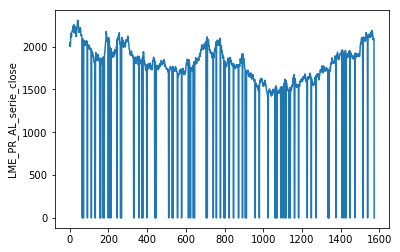

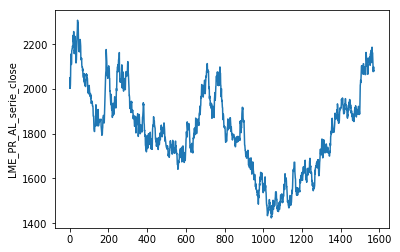

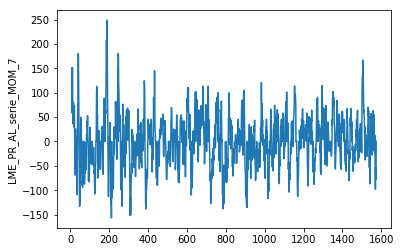

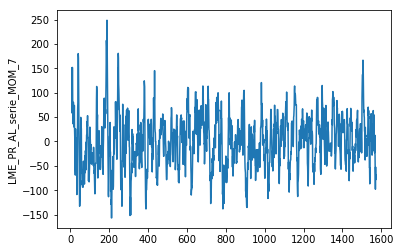

In [6]:
plt.plot(data['LME_PR_AL_serie_close'])
plt.ylabel('LME_PR_AL_serie_close')
plt.show()


al_serie=data['LME_PR_AL_serie_close']
cont=0
for v in al_serie:
    if v<=0:
        al_serie[cont]=al_serie[cont-1]
    cont+=1

plt.plot(al_serie)
plt.ylabel('LME_PR_AL_serie_close')
plt.show()


plt.plot(data['LME_PR_AL_serie_MOM_7'])
plt.ylabel('LME_PR_AL_serie_MOM_7')
plt.show()


al_mon7=data['LME_PR_AL_serie_MOM_7']
cont=0
for v in al_mon7:
    if v==0:
        al_mon7[cont]=al_mon7[cont-1]
    cont+=1

plt.plot(al_mon7)
plt.ylabel('LME_PR_AL_serie_MOM_7')
plt.show()






In [7]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import oneVar.lstm as lstm
import oneVar.lstm as time



Using TensorFlow backend.


In [8]:
X1_train, y1_train, X1_test, y1_test = lstm.load_data2(al_serie, 50, True)
X2_train, y2_train, X2_test, y2_test = lstm.load_data2(al_mon7, 50, True)
print(str(X1_train.shape))
print(str(y1_train.shape))
print(str(X1_test.shape))
print(str(y1_test.shape))

(1372, 50, 1)
(1372,)
(152, 50, 1)
(152,)


In [17]:
X1_train = X1_train.reshape(X1_train.shape[0], X1_train.shape[1], 1, X1_train.shape[2])
X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1, X2_train.shape[2])
X_train =  np.concatenate((X1_train, X2_train), axis=2)
X_train = np.squeeze(X_train, axis=3)

#y1_train = y1_train.reshape(y1_train.shape[0], 1)
#y2_train = y2_train.reshape(y2_train.shape[0], 1)
#y_train =  np.concatenate((y1_train, y2_train), axis=1)
y_train =  y1_train

X1_test = X1_test.reshape(X1_test.shape[0], X1_test.shape[1], 1, X1_test.shape[2])
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1, X2_test.shape[2])
X_test =  np.concatenate((X1_test, X2_test), axis=2)
X_test = np.squeeze(X_test, axis=3)

#y1_test = y1_test.reshape(y1_test.shape[0], 1)
#y2_test = y2_test.reshape(y2_test.shape[0], 1)
#y_test =  np.concatenate((y1_test, y2_test), axis=1)
y_test =  y1_test

print(str(X_train.shape))
print(str(y_train.shape))
print(str(X_test.shape))
print(str(y_test.shape))


(1372, 50, 2)
(1372,)
(152, 50, 2)
(152,)


In [18]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=2,
    output_dim=1,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = lstm.time.time()
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
print ('compilation time : ', lstm.time.time() - start)

compilation time :  0.04925084114074707


Train on 1303 samples, validate on 69 samples
Epoch 1/2
1303/1303 [==============================] - 2s - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/2
1303/1303 [====================

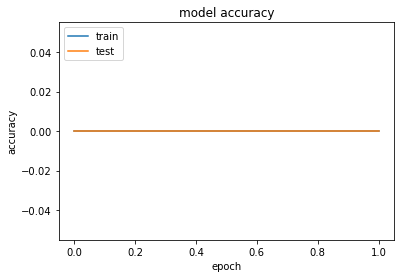

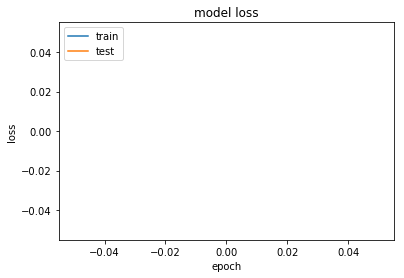

In [23]:
#Step 3 Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    nb_epoch=2,
    validation_split=0.05)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from numpy import newaxis

In [ ]:
def predict_sequences_multiple2(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            print("#" + str(j))
            #print(curr_frame[newaxis,:,:])
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            print(predicted)
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
            print(curr_frame)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [ ]:
predictions = lstm.predict_sequences_multiple(model, X_test, 50, 50)
#predictions = lstm.predict_sequence_full(model, X_test, 50)
lstm.plot_results_multiple(predictions, y_test, 50)